<a href="https://colab.research.google.com/github/CallumCoffey/ANN/blob/main/2_2_time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time-series Prediction

A time series is a sequence of observations, ordered in time. Forecasting involves training a model on historical data and using them to predict future observations. A simple example is a linear auto-regressive model. The linear auto-regressive (AR) model of a time-series $Z_t$ with $t=1,2,\dots,\infty$ is given by

$$\hat{z}_t = a_1 z_{t-1} + a_2 z_{t-2} + \cdots + a_p z_{t-p},$$

with $a_i \in \mathbb{R}$ for $i=1, \dots, p$ and $p$ the model lag. The prediction for a certain time $t$ is equal to a weighted sum of the previous values up to a certain lag $p$. In a similar way, the nonlinear (NAR) variant is described as

$$\hat{z}_t = f(z_{t-1}, z_{t-2}, \dots, z_{t-p}).$$

The figure below visualizes this process.

<img src="https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/assets/nar.jpg" width="600">

Remark that in this way, the time-series identification can be written as a classical black-box regression modeling problem $\hat{y}_t=f(x_t)$ with $y_t=z_t$ and $x_t=[z_{t-1}, z_{t-2}, \dots, z_{t-p}]$. When preparing the dataset and applying train/validation/test splits, it is important to prevent *data leakage* by respecting the temporal information flow. More precisely, a datapoint $z_t$ should not be part of two splits &mdash; either as input $x_t$ or target $y_t$ &mdash; and training (or validation) sets should not contain datapoints that occur after test datapoints.

In this notebook, we work on the time-series prediction problem using a multilayer perceptron (MLP) and a long short-term memory network (LSTM).

## Colab Setup
This part is only required when running this notebook "in the cloud" on [Google Colab](https://colab.research.google.com). When running it locally, skip this part and go to the next section.

In [ ]:
# Load some auxiliary files from github.
!wget https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/session2/SantaFe.npz

--2024-05-28 23:10:08--  https://raw.githubusercontent.com/KULasagna/ANN_DL_public/master/session2/SantaFe.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1598 (1.6K) [application/octet-stream]
Saving to: ‘SantaFe.npz’

SantaFe.npz         100%[===================>]   1.56K  --.-KB/s    in 0s      

2024-05-28 23:10:08 (15.6 MB/s) - ‘SantaFe.npz’ saved [1598/1598]



## Setup
Import all the necessary modules used throughout this notebook and define some helper methods to work with timeseries data and visualize the results.

In [ ]:
# Import the required modules for this notebook
from dataclasses import dataclass
import keras
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
@dataclass
class Fold:
  train_idxs: np.ndarray
  val_idxs: np.ndarray

def prepare_timeseries(timeseries, lag, validation_size=0, validation_folds=0):
  # Generate train (and validation) sets for the given timeseries and lag
  data = scipy.linalg.hankel(timeseries[:-lag], timeseries[-lag-1:-1])
  targets = timeseries[lag:]
  if validation_size > 0 and validation_folds > 0:
    tss = TimeSeriesSplit(test_size=validation_size, gap=lag)
    tss.n_splits = validation_folds
    folds = [Fold(train_idxs, val_idxs) for (train_idxs, val_idxs) in tss.split(data)]
    return data, targets, folds
  return data, targets

def shift(window, values):
  # Append new values to the given window (dropping the oldest values)
  result = np.empty(window.shape)
  values = np.atleast_1d(values)
  s = values.shape[0]
  result[:-s] = window[s:]
  result[-s:] = values
  return result

def normalize(timeseries, params=None):
  # Apply z-score normalization to the given timeseries
  if params is None:
    params = (np.mean(timeseries), np.std(timeseries))
  mu, sigma = params
  normalized = (timeseries - mu) / sigma
  return normalized, params

def rescale(timeseries, params):
  # Rescale the normalized timeseries back to its original values
  mu, sigma = params
  rescaled = mu + timeseries * sigma
  return rescaled

In [ ]:
def plot_history(history, title, filename=None):
  # Plot the train and validation loss curves
  fig, ax = plt.subplots(figsize=(10, 3))
  ax.semilogy(history.history['loss'], label='Train')
  if 'val_loss' in history.history:
    ax.semilogy(history.history['val_loss'], label='Validation')
  ax.legend()
  ax.set_xlabel('Epochs')
  ax.set_ylabel('Loss')
  plt.title(title)
  if filename is not None:
    plt.savefig(f"{filename}.svg")
  plt.show()

def plot_timeseries(timeseries_dict, title, filename=None):
  # Plot the given timeseries
  fig, ax = plt.subplots(figsize=(10, 3))
  for label, (start, ts) in timeseries_dict.items():
    ax.plot(start + np.arange(len(ts)), ts, label=label)
  ax.legend(ncol=1,loc='upper left', bbox_to_anchor=(0.65, 1))
  ax.set_xlabel('Timestep')
  ax.set_ylabel('Laser intensity')
  plt.title(title)
  if filename is not None:
    plt.savefig(f"{filename}.svg")
  plt.show()

## Santa Fe Laser Dataset
The Santa Fe laser dataset is obtained from a chaotic laser which can be described as a nonlinear dynamical system. The first $1000$ data points can be used for training and validation purposes. The aim is to predict the next $100$ points (it is forbidden to include these points in the training or validation sets!). Both datasets are stored in the `SantaFe.npz` file and are visualized below.

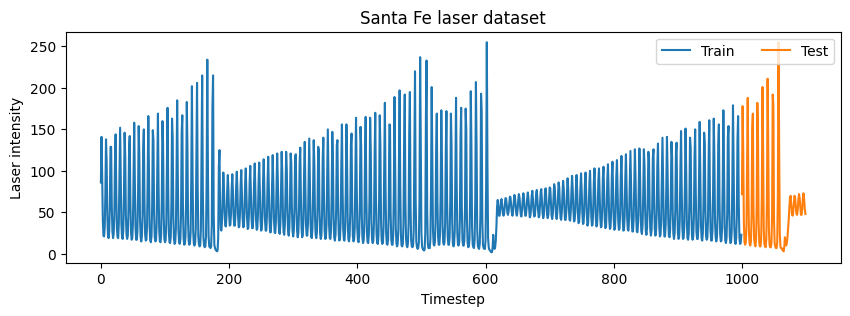

In [ ]:
santafe = np.load('SantaFe.npz')
train_series = santafe['A']
test_series = santafe['Acont']
plot_timeseries({
    'Train': (0, train_series),
    'Test': (len(train_series), test_series)
}, 'Santa Fe laser dataset')

To train the various nonlinear autoregressive models, it will be useful to prepare the timeseries dataset beforehand. We start by normalizing the train and test sets.

In [ ]:
normalized, params = normalize(santafe['A'])
normalized_test, _ = normalize(santafe['Acont'], params)

Next, the `prepare_timeseries` function is used to convert the timeseries into training data ($x_t$) and targets ($y_t$). Make sure you understand what the function does by trying it out on a small toy example.

In [ ]:
timeseries = np.arange(10)  # Increase this number to create a larger time series
lag = 3  # Try different values for the lag
data, targets, folds = prepare_timeseries(timeseries, lag, validation_size=1, validation_folds=2)  # Examine the effect of the validation size and number of validation folds
print(f"Original timeseries: {timeseries}")
print(f"Data for lag {lag}: {data}")
print(f"Targets: {targets}")
for i, fold in enumerate(folds):
  print(f"Fold {i}:")
  print(f"  Train:     data={data[fold.train_idxs]}, targets={targets[fold.train_idxs]}")
  print(f"  Validate:  data={data[fold.val_idxs]}, targets={targets[fold.val_idxs]}")

Original timeseries: [0 1 2 3 4 5 6 7 8 9]
Data for lag 3: [[0 1 2]
 [1 2 3]
 [2 3 4]
 [3 4 5]
 [4 5 6]
 [5 6 7]
 [6 7 8]]
Targets: [3 4 5 6 7 8 9]
Fold 0:
  Train:     data=[[0 1 2]
 [1 2 3]], targets=[3 4]
  Validate:  data=[[5 6 7]], targets=[8]
Fold 1:
  Train:     data=[[0 1 2]
 [1 2 3]
 [2 3 4]], targets=[3 4 5]
  Validate:  data=[[6 7 8]], targets=[9]


Once you understand the dataset structure, apply it to the normalized Santa Fe timeseries. You can come back to these cells later to change the values of the lag or validation parameters.

In [ ]:
# @title Parameters { run: "auto" }
lag = 73 # @param {type:"slider", min:1, max:100, step:1}
validation_size = 100 # @param {type:"slider", min:10, max:200, step:1}
validation_folds = 4 # @param {type:"slider", min:1, max:10, step:1}
# This is the hidden dimension of the MLP and LSTM networks trained later in this notebook
H = 84 # @param {type:"slider", min:10, max:100, step:1}

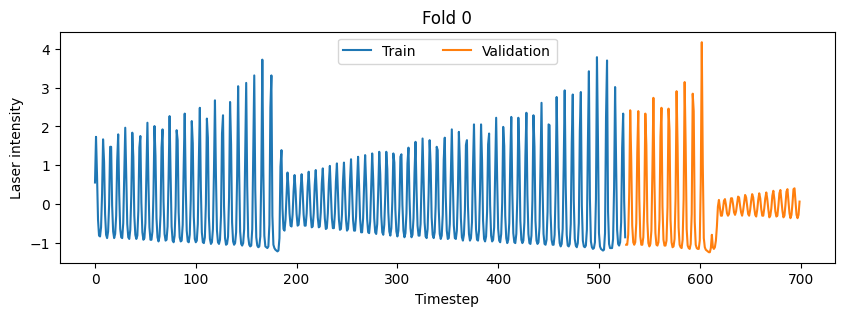

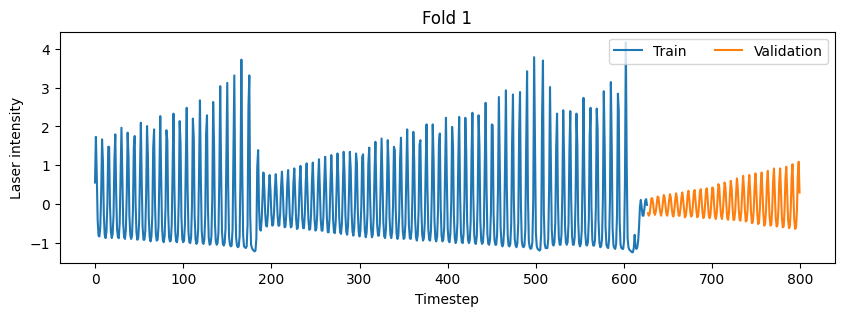

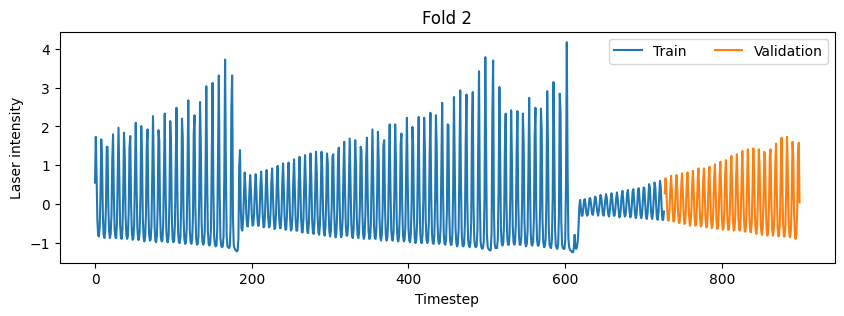

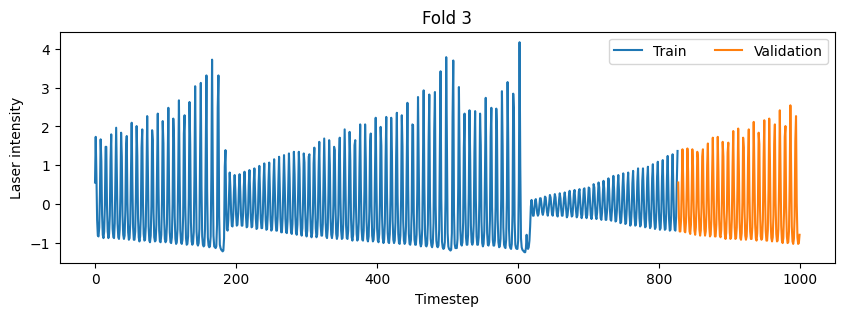

In [ ]:
data, targets, folds = prepare_timeseries(normalized, lag, validation_size, validation_folds)
# Plot train and validation data for each fold:
for f, fold in enumerate(folds):
  train_series = np.concatenate([data[fold.train_idxs[0]], targets[fold.train_idxs]])
  val_series = np.concatenate([data[fold.val_idxs[0]], targets[fold.val_idxs]])
  plot_timeseries({"Train": (0, train_series), "Validation": (len(train_series), val_series)}, f"Fold {f}")

## MLP
We now train a first nonlinear autoregressive (NAR) model on the training set and choose the hyperparameters based on the predictive performance on the validation sets. This first model is a multilayer perceptron (MLP) and training is done in feedforward mode using the prepared training set

$$\hat{z}_t = w^\top \tanh(V[z_{t-1}; z_{t-2}; \dots; z_{t-p}] + \beta).$$

In order to make predictions, the trained network is used in an iterative way as a recurrent network

$$\hat{z}_t = w^\top \tanh(V[\hat{z}_{t-1}; \hat{z}_{t-2}; \dots; \hat{z}_{t-p}] + \beta).$$

In [ ]:
# Define the MLP network architecture
def MLP(input_dim, hidden_dim, output_dim, activation='tanh'):
  return keras.Sequential([
    keras.layers.Input(shape=[input_dim]),  # Expect input of shape (B, I) with B batch size, I input size
    keras.layers.Dense(units=hidden_dim, activation=activation),  # Output of shape (B, H) with H hidden feature size
    keras.layers.Dense(units=output_dim)  # Output of shape (B, O) with O output size
  ])

Train the MLP on the last training fold. You can later put this code in a `for` loop to train on each of the training folds for determining the optimal hyperparameters using $N$-fold cross-validation.

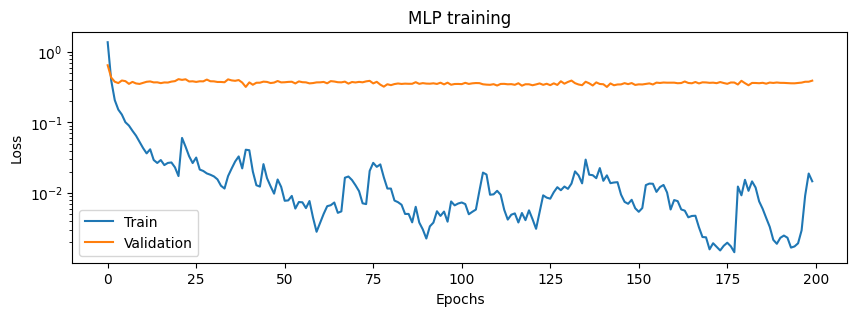

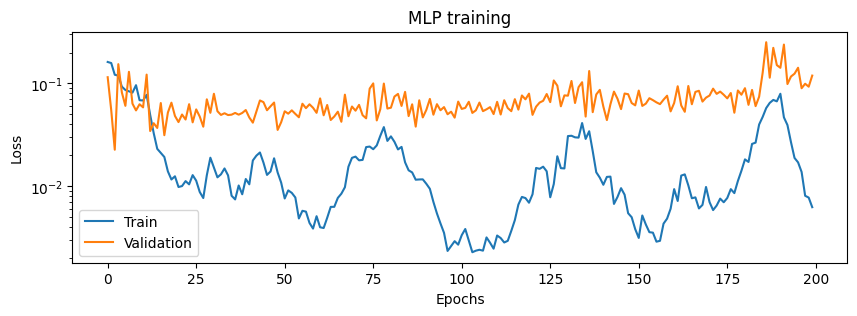

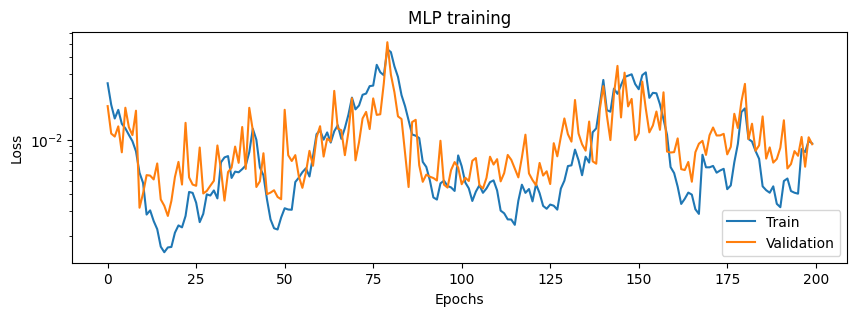

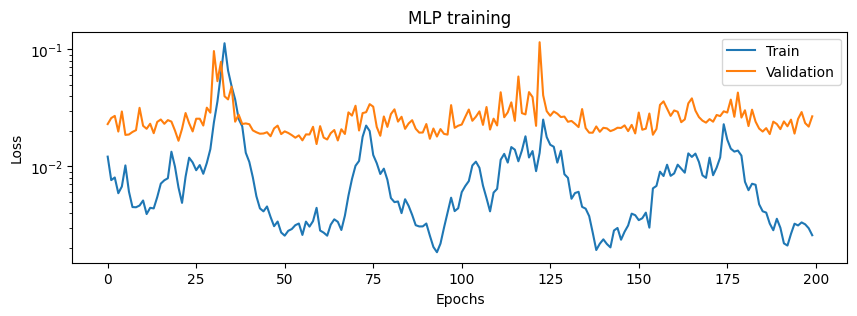

In [ ]:
net = MLP(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.01)
)
fold = folds[-1]
for fold in folds:
  history = net.fit(data[fold.train_idxs], targets[fold.train_idxs],
                    validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                    epochs=200, verbose=0)
  plot_history(history, "MLP training")

### **Exercise 1**
Investigate the model performance with different lags and number of neurons. Discuss how the model looks and explain clearly how you tune the parameters and what the influence on the final prediction is. Which combination of parameters gives the best performance (MSE) on the test set?

In [ ]:
# Evaluation on test set
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_mlp = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_mlp)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_mlp)}, "MLP prediction results on continuation of Santa Fe laser dataset")

ValueError: in user code:

    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_68" is incompatible with the layer: expected shape=(None, 82), found shape=(None, 70)


## LSTM
We now train the second model, which is a Long Short Term Memory (LSTM) network. These are a special kind of RNN, capable of learning long-term dependencies. LSTMs contain information outside the normal flow of the recurrent network in a gated cell. Information can be stored in, written to, or read from a cell, much like data in a computer's memory. The cell makes decisions about what to store and when to allow reads, writes and erasures, via gates that open and close. Those gates act on the signals they receive, and similar to the neural network's nodes, they block or pass on information based on its strength and importance, which they filter with their own sets of weights. Those weights, like the weights that modulate input and hidden states, are adjusted via the recurrent network's learning process. That is, the cells learn when to allow data to enter, leave or be deleted through the iterative process of making guesses, backpropagating the error, and adjusting weights via gradient descent.

In [ ]:
# Define the LSTM network structure
def LSTM(input_dim, hidden_dim, output_dim):
  return keras.Sequential([
    keras.layers.Input(shape=[None, input_dim], batch_size=1),  # LSTM layer expects input of shape (B, T, F) with B batch size, T timesteps, F feature size
    keras.layers.LSTM(units=hidden_dim, return_sequences=True, stateful=True),  # Output of shape (B, T, H) with H hidden state size
    keras.layers.Dense(units=output_dim)  # Output of shape (B, T, O) with O output size
  ])

class LSTMCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    self.model.reset_states()  # Make sure the LSTM's hidden state is reset after every epoch

Train the LSTM on the last training fold. You can later put this code in a `for` loop to train on each of the training folds for determining the optimal hyperparameters using $N$-fold cross-validation.

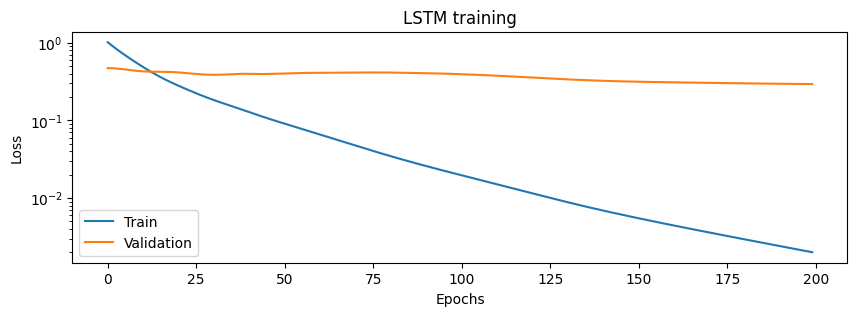

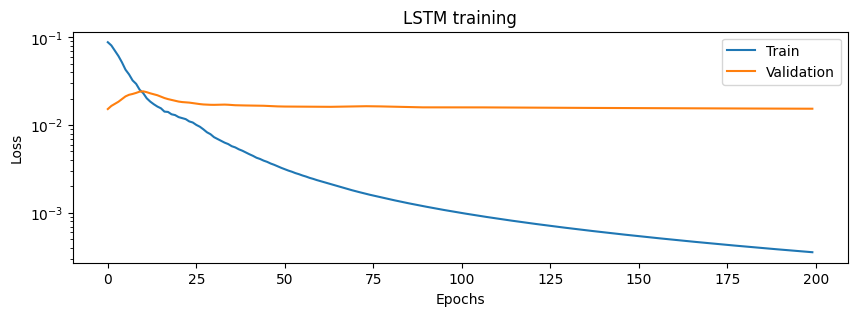

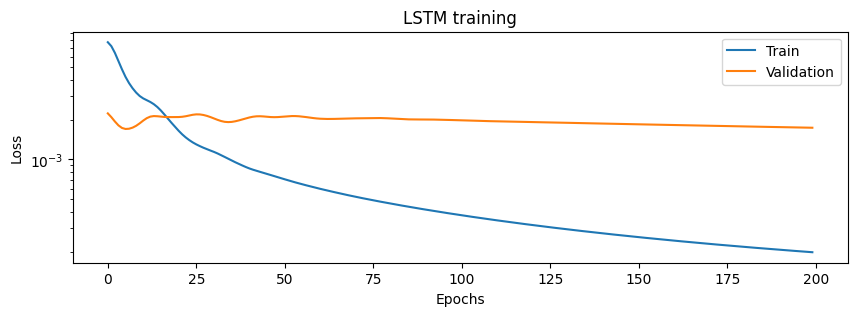

KeyboardInterrupt: 

In [ ]:
lag = 70
H = 47
net = LSTM(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

for fold in folds:
  history = net.fit(
      data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
      validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
      epochs=200, callbacks=[LSTMCallback()], verbose=0)
  plot_history(history, "LSTM training")

# LSTM Evaluation
net.reset_states()
net.predict(data.reshape(1, -1, lag), verbose=0)
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, 1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_lstm = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_lstm)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_lstm)}, "LSTM prediction results on continuation of Santa Fe laser dataset")

In [ ]:
plot_data = {"Test": (1000, test_series)}
for i, predictions in enumerate(LSTM_H_predict_list):
    plot_data[f"H={HList[i]}"] = (1000, predictions)
plot_data[f"MLP Predictions"] = (1000, MLP_predictions)
plot_data[f"LSTM Predictions"] = (1000, LSTM_predictions)

plot_timeseries(plot_data, "Prediction results on continuation of Santa Fe laser dataset")

### **Exercise 2**
Investigate the model performance with different lags and number of hidden states. Discuss how the model looks and explain clearly how you tune the parameters and what the influence on the final prediction is. Which combination of parameters gives the best performance (MSE) on the test set?

Compare the results of the recurrent MLP with the LSTM. Which model do you prefer and why?

In [ ]:
net = LSTM(lag, H, 1)
net.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
fold = folds[-1]
history = net.fit(
    data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
    validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
    epochs=150, callbacks=[LSTMCallback()], verbose=0)
plot_history(history, "LSTM training")

# LSTM Evaluation
net.reset_states()
net.predict(data.reshape(1, -1, lag), verbose=0)
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, 1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_lstm = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_lstm)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_lstm)}, "LSTM prediction results on continuation of Santa Fe laser dataset")


# LSTM Evaluation
net.reset_states()
net.predict(data.reshape(1, -1, lag), verbose=0)
test_data = shift(data[-1], targets[-1])
predictions = np.empty(normalized_test.shape)
for t in range(len(predictions)):
  predictions[t] = net.predict(test_data.reshape((1, 1, lag)), verbose=0).squeeze()
  test_data = shift(test_data, predictions[t])

# Rescale predictions
predictions_lstm = rescale(predictions, params)

# Compute the mean squared error between the predictions and test set
mse = np.mean((test_series - predictions_lstm)**2)
print("The MSE on the test set is: {:.3f}".format(mse))

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, predictions_lstm)}, "LSTM prediction results on continuation of Santa Fe laser dataset")

In [ ]:
# Comparison of both models
plot_timeseries({"Test": (1000, test_series), "MLP": (1000, predictions_mlp), "LSTM": (1000, predictions_lstm)}, "Prediction results on continuation of Santa Fe laser dataset")

# Testing


In [ ]:
def compile_MLP(lag, H):
    model = MLP(lag, H, 1)
    model.compile(
      loss=keras.losses.MeanSquaredError(),
      optimizer=keras.optimizers.Adam(learning_rate=0.01)
    )
    return model

def evaluate_MLP(model, data, targets, lag):
    test_data = shift(data[-1], targets[-1])
    predictions = np.empty(normalized_test.shape)
    for t in range(len(predictions)):
        predictions[t] = model.predict(test_data.reshape((1, lag)), verbose=0).squeeze()
        test_data = shift(test_data, predictions[t])
    # Rescale predictions
    predictions = rescale(predictions, params)
    # Calculate validation loss
    mse = np.mean((test_series - predictions)**2)
    return mse, predictions

def compile_LSTM(lag, H):
    model = LSTM(lag, H, 1)
    model.compile(
      loss=keras.losses.MeanSquaredError(),
      optimizer=keras.optimizers.Adam(learning_rate=0.001)
    )
    return model

def evaluate_LSTM(model, data, targets, lag):
    # LSTM Evaluation
    model.reset_states()
    model.predict(data.reshape(1, -1, lag), verbose=0)
    test_data = shift(data[-1], targets[-1])
    predictions = np.empty(normalized_test.shape)
    for t in range(len(predictions)):
      predictions[t] = model.predict(test_data.reshape((1, 1, lag)), verbose=0).squeeze()
      test_data = shift(test_data, predictions[t])

    # Rescale predictions
    predictions = rescale(predictions, params)

    # Compute the mean squared error between the predictions and test set
    mse = np.mean((test_series - predictions)**2)
    return mse, predictions
# # Comparison of both models-------------------------------------------------
# plot_timeseries({"Test": (1000, test_series), "MLP": (1000, predictions_mlp), "LSTM": (1000, predictions_lstm)}, "Prediction results on continuation of Santa Fe laser dataset")
# print("The MSE on the test set is: {:.3f}".format(LSTMmse))

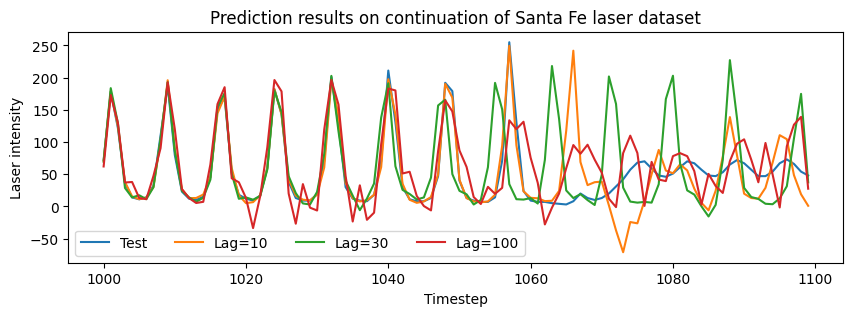

In [ ]:
#MSP Lag test
laglist = [10,30,100]
MLP_lag_mse_list = []
MLP_lag_history_list = []
MLP_lag_predict_list = []
for lag in laglist:
    H = 20
    data, targets, folds = prepare_timeseries(normalized, lag, validation_size = 100, validation_folds = 4)

    model = compile_MLP(lag,H)

    for fold in folds:
      history = model.fit(data[fold.train_idxs], targets[fold.train_idxs],
                        validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                        epochs=200, verbose=0)

    mse, predictions = evaluate_MLP(model, data, targets, lag)
    print("The MSE on the test set is: {:.3f}".format(mse))
    MLP_lag_mse_list.append(mse)
    MLP_lag_predict_list.append(predictions)

MLP_plot_data = {"Test": (1000, test_series)}
for i, predictions in enumerate(MLP_lag_predict_list):
    MLP_plot_data[f"Lag={laglist[i]}"] = (1000, predictions)

plot_timeseries(MLP_plot_data, "Prediction results on continuation of Santa Fe laser dataset")

The MSE on the test set is: 2643.726
The MSE on the test set is: 505.501
The MSE on the test set is: 2617.313


<Figure size 640x480 with 0 Axes>

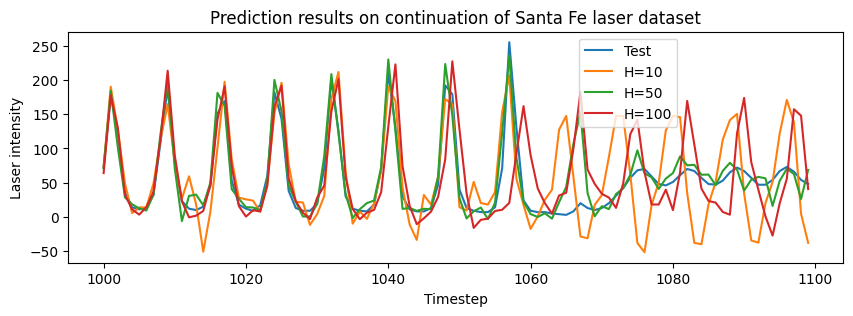

In [ ]:
#MSP H test
HList = [10, 50, 100]
lag = 80
MLP_H_mse_list = []
MLP_H_predict_list = []
MLP_H_history_list = []
plt.figure()
for H in HList:
    data, targets, folds = prepare_timeseries(normalized, lag, validation_size = 100, validation_folds = 4)

    # create model
    model = compile_MLP(lag,H)

    for fold in folds:
      history = model.fit(data[fold.train_idxs], targets[fold.train_idxs],
                        validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
                        epochs=200, verbose=0)

    mse, predictions = evaluate_MLP(model, data, targets, lag)
    print("The MSE on the test set is: {:.3f}".format(mse))
    MLP_H_mse_list.append(mse)
    MLP_H_predict_list.append(predictions)

plot_data = {"Test": (1000, test_series)}
for i, predictions in enumerate(MLP_H_predict_list):
    plot_data[f"H={HList[i]}"] = (1000, predictions)

plot_timeseries(plot_data, "Prediction results on continuation of Santa Fe laser dataset")

The MSE on the test set is: 1614.334
The MSE on the test set is: 93.786
The MSE on the test set is: 404.090


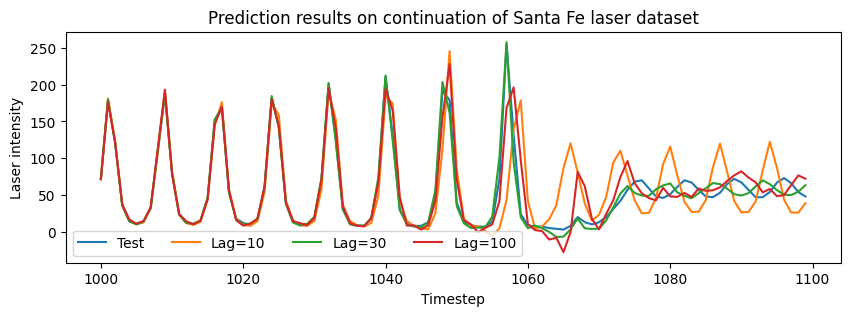

In [ ]:
#LSTM lag testing
H = 20

LSTM_lag_mse_list = []
LSTM_lag_history_list = []
LSTM_lag_predict_list = []
for lag in laglist:
    data, targets, folds = prepare_timeseries(normalized, lag, validation_size = 100, validation_folds = 4)

    model = compile_LSTM(lag,H)

    for fold in folds:
      history = model.fit(
          data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
          validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
          epochs=200, callbacks=[LSTMCallback()], verbose=0)

    mse, predictions = evaluate_LSTM(model, data, targets, lag)
    print("The MSE on the test set is: {:.3f}".format(mse))
    LSTM_lag_mse_list.append(mse)
    LSTM_lag_predict_list.append(predictions)

LSTM_plot_data = {"Test": (1000, test_series)}
for i, predictions in enumerate(LSTM_lag_predict_list):
    LSTM_plot_data[f"Lag={laglist[i]}"] = (1000, predictions)

plot_timeseries(LSTM_plot_data, "Prediction results on continuation of Santa Fe laser dataset")

The MSE on the test set is: 392.303
The MSE on the test set is: 234.726
The MSE on the test set is: 164.079


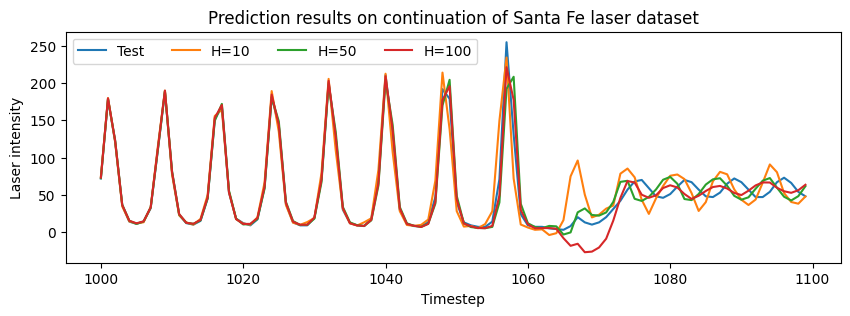

In [ ]:
#LSTM H testing
lag = 40

LSTM_H_mse_list = []
LSTM_H_predict_list = []
LSTM_H_history_list = []
for H in HList:

    data, targets, folds = prepare_timeseries(normalized, lag, validation_size = 100, validation_folds = 4)

    # create model
    model = compile_LSTM(lag,H)

    for fold in folds:
      history = model.fit(
          data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
          validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
          epochs=200, callbacks=[LSTMCallback()], verbose=0)

    mse, predictions = evaluate_LSTM(model, data, targets, lag)
    print("The MSE on the test set is: {:.3f}".format(mse))
    LSTM_H_mse_list.append(mse)
    LSTM_H_predict_list.append(predictions)

plot_data = {"Test": (1000, test_series)}
for i, predictions in enumerate(LSTM_H_predict_list):
    plot_data[f"H={HList[i]}"] = (1000, predictions)

plot_timeseries(plot_data, "Prediction results on continuation of Santa Fe laser dataset")

In [ ]:
print(MLP_lag_mse_list)
print(MLP_H_mse_list)
print(LSTM_lag_mse_list)
print(LSTM_H_mse_list)

[1410.0415682540388, 3900.9304087165137, 1340.6160178388288]
[4655.484003782174, 3828.975287620335, 821.9587935048866]
[1614.3337800642269, 93.78622989811738, 404.0899873681428]
[392.303354417734, 234.72632690943382, 164.07895634006312]


# Hyperparameter tuning


In [ ]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.3 MB/s eta 0:00:00


[I 2024-05-29 00:02:01,687] A new study created in memory with name: no-name-21c0c1c1-5ab3-4221-ba90-947e9ae1eede
[I 2024-05-29 00:02:33,923] Trial 0 finished with value: 5133.003533160227 and parameters: {'lag': 29, 'H': 58}. Best is trial 0 with value: 5133.003533160227.
[I 2024-05-29 00:02:52,843] Trial 1 finished with value: 2076.7177461729493 and parameters: {'lag': 92, 'H': 97}. Best is trial 1 with value: 2076.7177461729493.
[I 2024-05-29 00:03:16,965] Trial 2 finished with value: 189.33969121093168 and parameters: {'lag': 95, 'H': 90}. Best is trial 2 with value: 189.33969121093168.
[I 2024-05-29 00:03:36,064] Trial 3 finished with value: 14864.241103965347 and parameters: {'lag': 2, 'H': 100}. Best is trial 2 with value: 189.33969121093168.
[I 2024-05-29 00:04:02,974] Trial 4 finished with value: 2032.1625708746294 and parameters: {'lag': 51, 'H': 72}. Best is trial 2 with value: 189.33969121093168.
[I 2024-05-29 00:04:22,282] Trial 5 finished with value: 1580.1267380646868 an

Best parameters: {'lag': 82, 'H': 90}


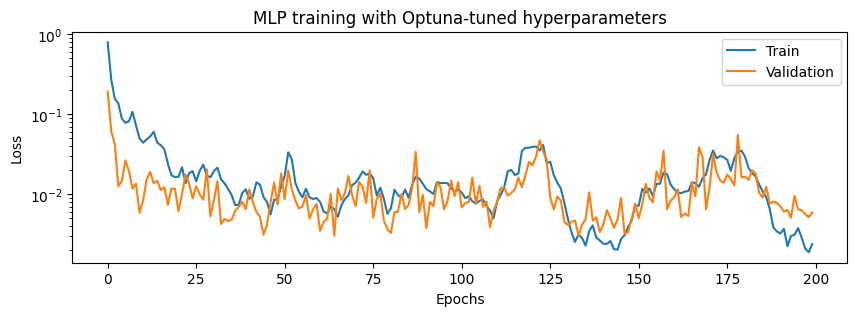

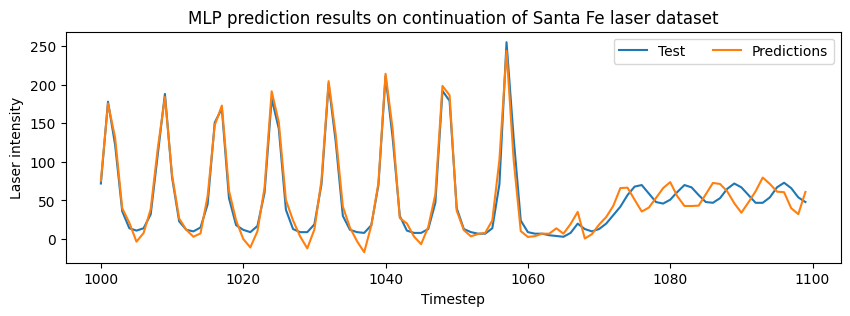

The MSE on the test set is: 184.487


In [ ]:
import optuna
import tensorflow as tf
from tensorflow import keras
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

# Define a custom Keras callback for pruning
class KerasPruningCallback(keras.callbacks.Callback):
    def __init__(self, trial, monitor='val_loss'):
        super(KerasPruningCallback, self).__init__()
        self.trial = trial
        self.monitor = monitor

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        current_score = logs.get(self.monitor)
        if current_score is None:
            return

        self.trial.report(current_score, step=epoch)
        if self.trial.should_prune():
            self.model.stop_training = True
            raise optuna.TrialPruned(f'Trial was pruned at epoch {epoch}.')


early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop training if no improvement after 10 epochs
    restore_best_weights=True  # Restore weights from the epoch with the best validation loss
)

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to be optimized
    lag = trial.suggest_int('lag', 1, 100)
    H = trial.suggest_int('H', 10, 100)
    data, targets, folds = prepare_timeseries(normalized, lag, validation_size = 100, validation_folds = 4)

    # create model
    model = compile_MLP(lag,H)

    # fold = folds[-1]
    #fit the model
    # for fold in folds:
    #   model.fit(data[fold.train_idxs], targets[fold.train_idxs],
    #                     validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
    #                     epochs=200, callbacks=[KerasPruningCallback(trial, 'val_loss')],verbose=0)
    for fold in folds:
      model.fit(data[fold.train_idxs], targets[fold.train_idxs],
          validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
          epochs=200,callbacks=[early_stopping],verbose=0)

    mse, _ = evaluate_MLP(model, data, targets, lag)
    return mse

# Run the Optuna optimization
# MLP_study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=20))
MLP_study = optuna.create_study(direction='minimize')
MLP_study.optimize(objective, n_trials=20)

optuna.visualization.plot_optimization_history(MLP_study)

# Get the best hyperparameters
best_params = MLP_study.best_params
print(f"Best parameters: {best_params}")

# Retrain the model with the best hyperparameters on the full dataset
MLP_best_lag = best_params['lag']
MLP_best_H = best_params['H']

In [ ]:
study = MLP_study
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_slice(study).show()
optuna.visualization.plot_contour(study).show()

[I 2024-05-29 00:09:38,075] A new study created in memory with name: no-name-ef14623a-cb1d-445f-8e96-48dd3c728cef
[I 2024-05-29 00:12:00,101] Trial 0 finished with value: 150.5725871755829 and parameters: {'lag': 41, 'H': 98}. Best is trial 0 with value: 150.5725871755829.
[I 2024-05-29 00:13:01,108] Trial 1 finished with value: 233.087690814992 and parameters: {'lag': 86, 'H': 69}. Best is trial 0 with value: 150.5725871755829.
[I 2024-05-29 00:15:47,479] Trial 2 finished with value: 289.0832836020125 and parameters: {'lag': 67, 'H': 68}. Best is trial 0 with value: 150.5725871755829.
[I 2024-05-29 00:17:03,750] Trial 3 finished with value: 477.19148412570723 and parameters: {'lag': 99, 'H': 87}. Best is trial 0 with value: 150.5725871755829.
[I 2024-05-29 00:18:15,877] Trial 4 finished with value: 4127.384239010339 and parameters: {'lag': 2, 'H': 45}. Best is trial 0 with value: 150.5725871755829.
[I 2024-05-29 00:19:56,928] Trial 5 finished with value: 292.5202725488861 and paramete

Best parameters: {'lag': 70, 'H': 47}


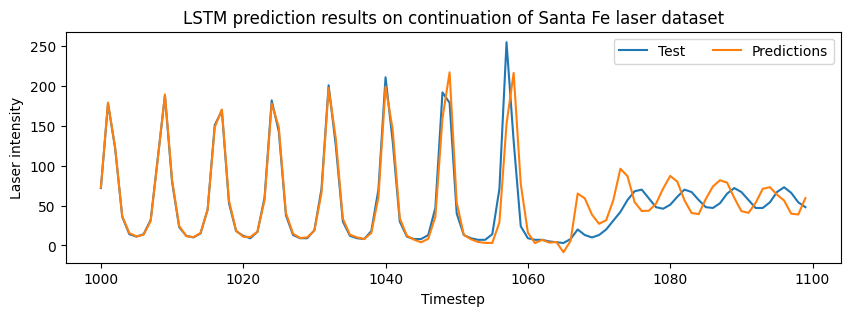

The MSE on the test set is: 459.673


In [ ]:
#optuna for LSTM
import optuna
import tensorflow as tf
from tensorflow import keras
import numpy as np
np.random.seed(42)
tf.random.set_seed(42)

# Define a custom Keras callback for pruning
class KerasPruningCallback(keras.callbacks.Callback):
    def __init__(self, trial, monitor='val_loss'):
        super(KerasPruningCallback, self).__init__()
        self.trial = trial
        self.monitor = monitor

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            return
        current_score = logs.get(self.monitor)
        if current_score is None:
            return

        self.trial.report(current_score, step=epoch)
        if self.trial.should_prune():
            self.model.stop_training = True
            raise optuna.TrialPruned(f'Trial was pruned at epoch {epoch}.')


early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=10,          # Stop training if no improvement after 10 epochs
    restore_best_weights=True  # Restore weights from the epoch with the best validation loss
    )
# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to be optimized
    lag = trial.suggest_int('lag', 1, 100)
    H = trial.suggest_int('H', 10, 100)
    data, targets, folds = prepare_timeseries(normalized, lag, validation_size = 100, validation_folds = 4)

    # create model
    model = compile_LSTM(lag,H)

    #fit the model
    for fold in folds:
        model.fit(
          data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
          validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
          epochs=150, callbacks=[early_stopping,LSTMCallback()], verbose=0)
      # model.fit(
      #     data[fold.train_idxs].reshape((1, -1, lag)), targets[fold.train_idxs].reshape((1, -1)),
      #     validation_data=(data[fold.val_idxs].reshape((1, -1, lag)), targets[fold.val_idxs].reshape((1, -1))),
      #     epochs=150, callbacks=[KerasPruningCallback(trial, 'val_loss'),LSTMCallback()], verbose=0)

    mse, _ = evaluate_LSTM(model, data, targets, lag)
    return mse


# Run the Optuna optimization
# LSTM_study = optuna.create_study(direction='minimize', pruner=optuna.pruners.MedianPruner(n_startup_trials=10, n_warmup_steps=20))
LSTM_study = optuna.create_study(direction='minimize')
LSTM_study.optimize(objective, n_trials=20)

optuna.visualization.plot_optimization_history(LSTM_study)

# Get the best hyperparameters
best_params = LSTM_study.best_params
print(f"Best parameters: {best_params}")

# Retrain the model with the best hyperparameters on the full dataset
LSTM_best_lag = best_params['lag']
LSTM_best_H = best_params['H']

In [ ]:
study = LSTM_study
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_slice(study).show()
optuna.visualization.plot_contour(study).show()

# Conclusion


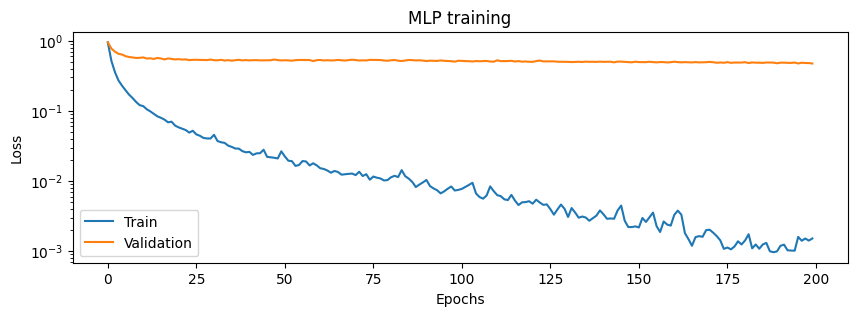

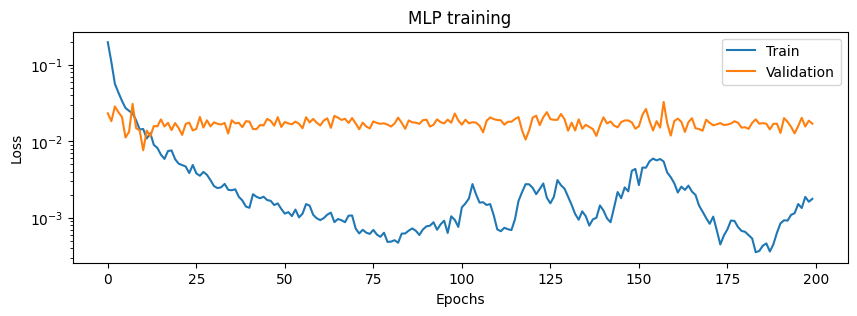

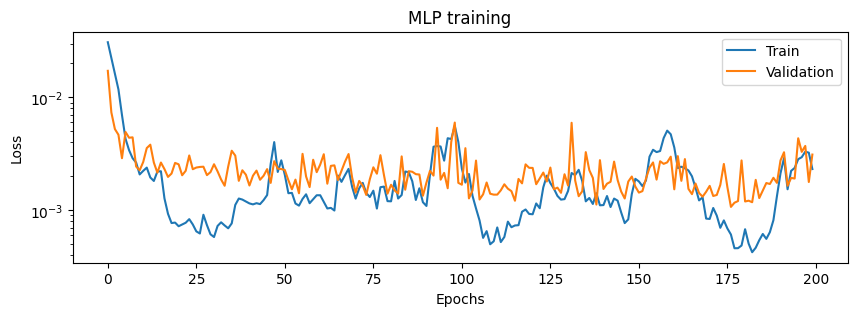

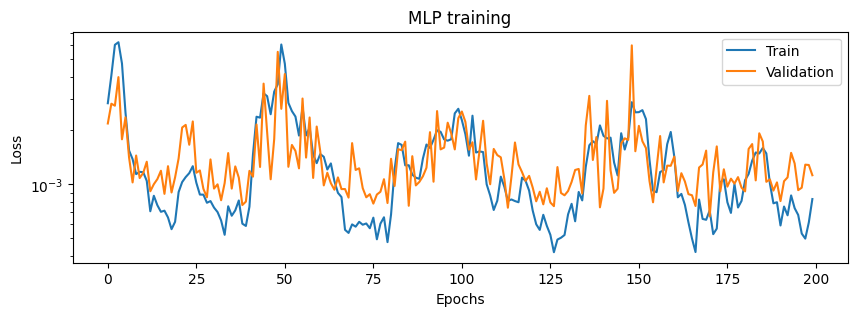

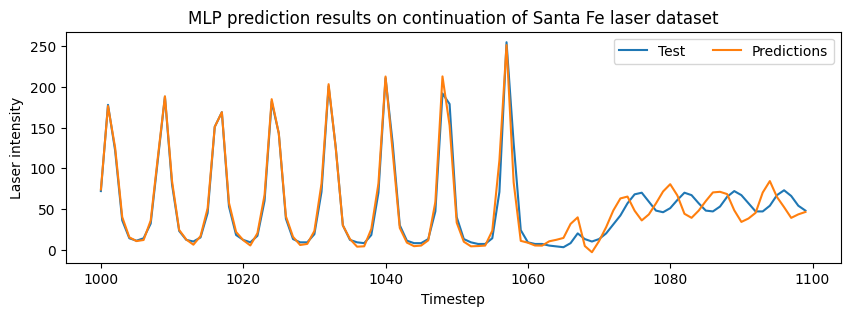

The MSE on the test set is: 192.639


In [ ]:
# Retrain the model with the best hyperparameters on the full dataset
# MLP_best_lag = best_params['lag']
# MLP_best_H = best_params['H']
MLP_best_lag = 82
MLP_best_H = 90
data, targets, folds = prepare_timeseries(normalized, MLP_best_lag, validation_size = 100, validation_folds = 4)

MLP_model = MLP(MLP_best_lag, MLP_best_H, 1)
MLP_model.compile(
  loss=keras.losses.MeanSquaredError(),
  optimizer=keras.optimizers.Adam(learning_rate=0.001)
)
for fold in folds:
  history = MLP_model.fit(data[fold.train_idxs], targets[fold.train_idxs],
      validation_data=(data[fold.val_idxs], targets[fold.val_idxs]),
      epochs=200,callbacks=[],verbose=0)
  plot_history(history, "MLP training")

MLP_mse, MLP_predictions = evaluate_MLP(MLP_model, data, targets, MLP_best_lag)

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, MLP_predictions)}, "MLP prediction results on continuation of Santa Fe laser dataset")
print("The MSE on the test set is: {:.3f}".format(MLP_mse))

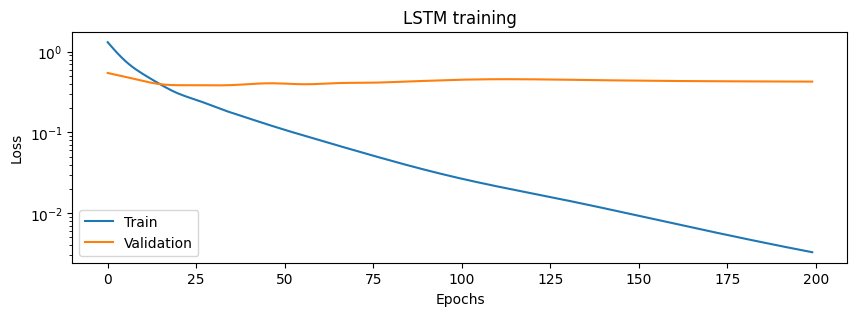

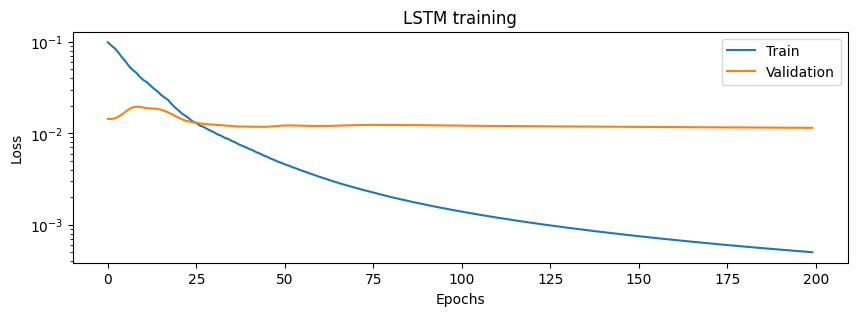

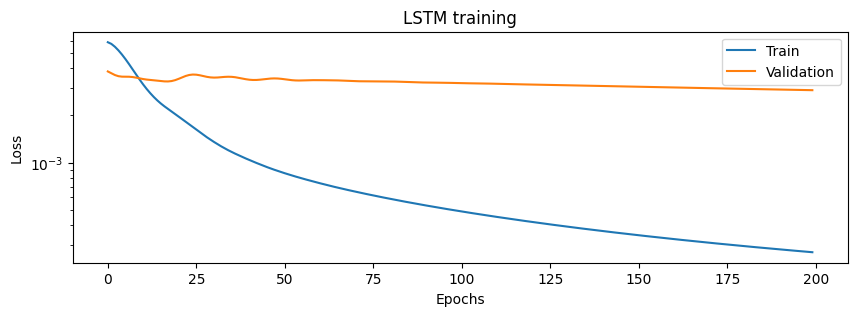

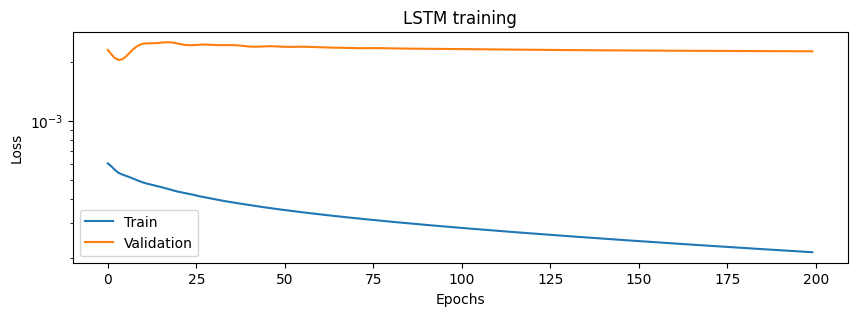

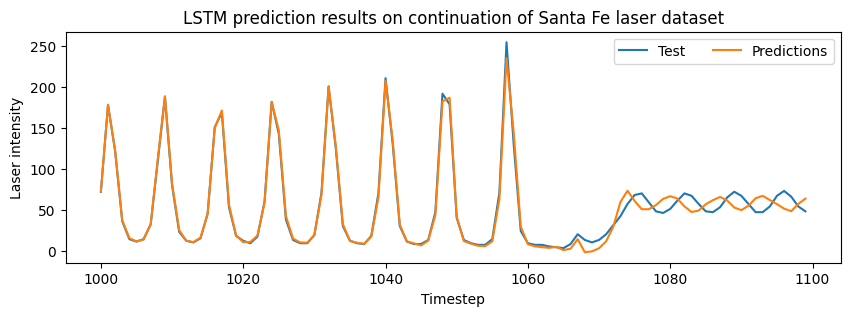

The MSE on the test set is: 70.478


In [ ]:
# Retrain the model with the best hyperparameters on the full dataset
data, targets, folds = prepare_timeseries(normalized, LSTM_best_lag, validation_size = 100, validation_folds = 4)

LSTM_model = compile_LSTM(LSTM_best_lag,LSTM_best_H)

# fold = folds[-1]
# history = LSTM_model.fit(
# data[fold.train_idxs].reshape((1, -1, LSTM_best_lag)), targets[fold.train_idxs].reshape((1, -1)),
# validation_data=(data[fold.val_idxs].reshape((1, -1, LSTM_best_lag)), targets[fold.val_idxs].reshape((1, -1))),
# epochs=200, callbacks=[LSTMCallback()], verbose=0)
# plot_history(history, "LSTM training")
for fold in folds:
  history = LSTM_model.fit(
      data[fold.train_idxs].reshape((1, -1, LSTM_best_lag)), targets[fold.train_idxs].reshape((1, -1)),
      validation_data=(data[fold.val_idxs].reshape((1, -1, LSTM_best_lag)), targets[fold.val_idxs].reshape((1, -1))),
      epochs=200, callbacks=[LSTMCallback()], verbose=0)
  plot_history(history, "LSTM training")

LSTM_mse, LSTM_predictions = evaluate_LSTM(LSTM_model, data, targets, LSTM_best_lag)

# Plot
plot_timeseries({"Test": (1000, test_series), "Predictions": (1000, LSTM_predictions)}, "LSTM prediction results on continuation of Santa Fe laser dataset")
print("The MSE on the test set is: {:.3f}".format(LSTM_mse))

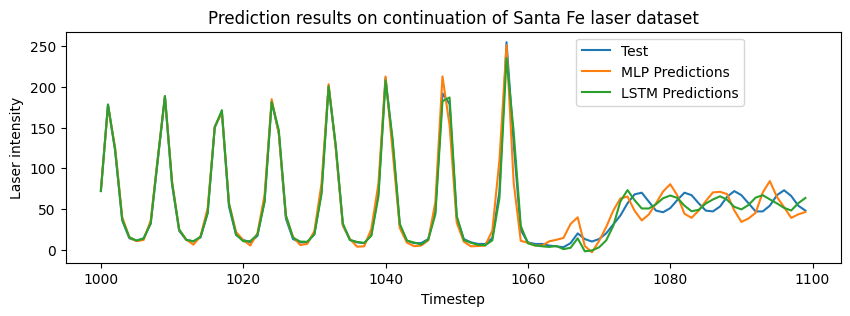

In [ ]:
plot_data = []
plot_data = {"Test": (1000, test_series)}
plot_data[f"MLP Predictions"] = (1000, MLP_predictions)
plot_data[f"LSTM Predictions"] = (1000, LSTM_predictions)

plot_timeseries(plot_data, "Prediction results on continuation of Santa Fe laser dataset")